In [2]:
import os
import pandas as pd
from sqlalchemy import create_engine, text
from dotenv import load_dotenv
from urllib.parse import quote_plus

def load_csv_to_postgres():
    """
    Reads a CSV file, adds 'analysis_status' column,
    and loads the contents into a PostgreSQL table.
    Lets Postgres handle the auto-increment `id`.
    """
    # --- 1. Load config ---
    load_dotenv(override=True)

    db_user = os.getenv("DB_USER")
    db_password = os.getenv("DB_PASSWORD")
    db_host = os.getenv("DB_HOST")
    db_port = os.getenv("DB_PORT")
    db_name = os.getenv("DB_NAME")

    csv_file_path = "data/sampled_amazon_data.csv"
    table_name = "raw_reviews"

    if not all([db_user, db_password, db_host, db_port, db_name]):
        print("Error: Database configuration is missing in the .env file.")
        return

    try:
        # --- 2. Read CSV ---
        print(f"Reading CSV file from '{csv_file_path}'...")
        df = pd.read_csv(csv_file_path)
        print(f"✅ Loaded {len(df)} rows from CSV.")

        # --- 3. Add 'analysis_status' column ---
        df["analysis_status"] = "pending"

        # --- 4. Connect to Postgres ---
        encoded_password = quote_plus(db_password)
        connection_url = f"postgresql://{db_user}:{encoded_password}@{db_host}:{db_port}/{db_name}"
        engine = create_engine(connection_url)
        print(f"🔌 Connecting to '{db_name}'...")

        # --- 5. Create table if not exists ---
        with engine.connect() as conn:
            conn.execute(text(f"""
                CREATE TABLE IF NOT EXISTS {table_name} (
                    id SERIAL PRIMARY KEY,
                    "ASIN" TEXT,
                    "Title" TEXT,
                    "Description" TEXT,
                    "ImageURL" TEXT,
                    "Rating" FLOAT,
                    "Verified" BOOLEAN,
                    "ReviewTime" TIMESTAMP,
                    "Review" TEXT,
                    "Summary" TEXT,
                    "Domestic Shipping" TEXT,
                    "International Shipping" TEXT,
                    "Sentiment" FLOAT,
                    "Region" TEXT,
                    analysis_status TEXT
                );
            """))
            conn.commit()

        # --- 6. Append data to table ---
        print(f"📥 Loading data into '{table_name}'...")

        # --- Change ReviewTime to to latest by shifting the time ---
        
        # convert ReviewTime into date format then find the lastest date from df['ReviewTime']
        df['ReviewTime'] = pd.to_datetime(df['ReviewTime'], errors='coerce')
        latest_date = df['ReviewTime'].max()

        # find the no. of days from today
        days_diff = (pd.Timestamp.now() - latest_date).days

        # increment the each ReviewTime by days_diff -1
        df['ReviewTime'] = df['ReviewTime'] + pd.Timedelta(days=days_diff - 1)
        # so, the latest ReviewTime is now the yesterday's date

        df.to_sql(
            name=table_name,
            con=engine,
            if_exists="append",
            index=False
        )

        print(f"✅ Success! {len(df)} rows inserted into '{table_name}'.")

    except FileNotFoundError:
        print(f"❌ Error: CSV file '{csv_file_path}' not found.")
    except Exception as e:
        print(f"❌ An error occurred: {e}")


In [3]:
load_csv_to_postgres()

Reading CSV file from 'data/sampled_amazon_data.csv'...
✅ Loaded 200 rows from CSV.
🔌 Connecting to 'cx_hackathon_db'...
📥 Loading data into 'raw_reviews'...
✅ Success! 200 rows inserted into 'raw_reviews'.


## Getting Data from Postgres

In [2]:
import os
import pandas as pd
from sqlalchemy import create_engine, engine as sqlalchemy_engine
from dotenv import load_dotenv
from urllib.parse import quote_plus
from typing import Optional

In [3]:
import os
import pandas as pd
from sqlalchemy import create_engine, text
from dotenv import load_dotenv
from urllib.parse import quote_plus

def create_db_engine() -> Optional[sqlalchemy_engine.Engine]:
    """
    Reads database credentials from the .env file and creates a
    SQLAlchemy engine.

    Returns:
        sqlalchemy_engine.Engine: A SQLAlchemy engine instance, or None if config is missing.
    """

    load_dotenv()

    db_user = os.getenv("DB_USER")
    db_password = os.getenv("DB_PASSWORD")
    db_host = os.getenv("DB_HOST")
    db_port = os.getenv("DB_PORT")
    db_name = os.getenv("DB_NAME")

    if not all([db_user, db_password, db_host, db_port, db_name]):
        print("Error: Database configuration is missing in the .env file.")
        return None
    
    try:
        encoded_password = quote_plus(db_password)
        connection_url = f"postgresql://{db_user}:{encoded_password}@{db_host}:{db_port}/{db_name}"
        engine = create_engine(connection_url)
        # Test the connection to ensure it's valid
        engine.connect()
        return engine
    except Exception as e:
        print(f"Error creating database engine: {e}")
        return None



In [6]:

def fetch_pending_reviews_from_sql(engine: sqlalchemy_engine.Engine, limit: int = 100) -> pd.DataFrame:
    """
    Fetches a batch of reviews with 'pending' status using a provided database engine.

    Args:
        engine: An active SQLAlchemy engine.
        limit (int): The maximum number of reviews to fetch.

    Returns:
        pd.DataFrame: A pandas DataFrame containing the pending reviews.
    """
    table_name = "raw_reviews"
    sql_query = f"""
        SELECT * FROM {table_name} 
        WHERE analysis_status = 'pending' 
        LIMIT {limit};
    """
    
    try:
        print(f"Fetching up to {limit} pending reviews...")
        df = pd.read_sql_query(sql_query, engine)
        return df
    except Exception as e:
        print(f"Error fetching data: {e}")
        return pd.DataFrame()

In [17]:
print("Connecting to the database")
db_engine = create_db_engine()

if db_engine:
    print("Connection successful.")
    pending_reviews_df = fetch_pending_reviews_from_sql(engine=db_engine, limit=2000)
    
    if not pending_reviews_df.empty:
            print(f"\n✅ Success! Fetched {len(pending_reviews_df)} pending reviews.")
            print("--- DataFrame Head ---")
            print(pending_reviews_df.head())
    else:
        print("\nNo pending reviews found or an error occurred during fetching.")
else:
    print("Could not create database engine. Aborting.")


Connecting to the database
Connection successful.
Fetching up to 2000 pending reviews...

✅ Success! Fetched 200 pending reviews.
--- DataFrame Head ---
         ASIN                                              Title  \
0  B002K6AHQY   CND Vinylux Weekly Nail Polish, Rock Royalty,...   
1  B00176GSEI  HOT TOOLS Professional 24k Gold Extra-Long Bar...   
2  B000ASDGK8                   BaBylissPRO Ceramix Xtreme Dryer   
3  B002K6AHQY   CND Vinylux Weekly Nail Polish, Rock Royalty,...   
4  B00FYSZDQ4                            COLOR WOW Root Cover Up   

                                         Description  \
0  Vinylux weekly polish and weekly top coat are ...   
1  Hot Tools Professional 1110 Curling Iron with ...   
2  2000 Watt ceramic technology dryer with concen...   
3  Vinylux weekly polish and weekly top coat are ...   
4  Color Wow root cover up, winner of 44 major be...   

                                            ImageURL  Rating  Verified  \
0  https://images-na.ssl-im

In [107]:
import pandas as pd

PATH = "/Users/nike/Downloads/meta_Luxury_Beauty.json.gz"

df = pd.read_json(PATH, lines=True)

In [108]:
df.head(2)

,category,tech1,description,fit,title,also_buy,tech2,brand,feature,rank,also_view,details,main_cat,similar_item,date,price,asin,imageURL,imageURLHighRes
0,[],,[After a long day of handling thorny situation...,,Crabtree &amp; Evelyn - Gardener's Ultra-Moist...,"[B00GHX7H0A, B00FRERO7G, B00R68QXCS, B000Z65AZ...",,,[],"4,324 in Beauty & Personal Care (","[B00FRERO7G, B00GHX7H0A, B07GFHJRMX, B00TJ3NBN...",{' Product Dimensions: ': '2.2 x 2.2 ...,Luxury Beauty,,NaT,$30.00,B00004U9V2,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...
1,[],,[If you haven't experienced the pleasures of b...,,AHAVA Bath Salts,[],,,[],"1,633,549 in Beauty & Personal Care (",[],{' Product Dimensions: ': '3 x 3.5 x ...,Luxury Beauty,,NaT,,B0000531EN,[],[]


In [109]:
df.shape

(12299, 19)

In [110]:
from bs4 import BeautifulSoup
import re

def clean_description(desc):
    # desc is a list, join to string
    text = " ".join(desc) if isinstance(desc, list) else str(desc)
    # Remove HTML tags and links
    soup = BeautifulSoup(text, "html.parser")
    # Remove anchor tags but keep their text
    for a in soup.find_all('a'):
        a.unwrap()
    # Remove any URLs
    cleaned = re.sub(r'http\S+', '', soup.get_text())
    return cleaned.strip()

df['description'] = df['description'].apply(clean_description)
df.shape

(12299, 19)

In [111]:
keywords = ["lotion", "cream", "dryer", "soap", "powder"]
filtered_df = df[df['title'].str.contains('|'.join(keywords), case=False, na=False)]
filtered_df.shape

(1948, 19)

In [112]:
# Filter rows where 'description' column contains at least 100 words
filtered_df = filtered_df[filtered_df['description'].apply(lambda desc: len(str(desc).split()) >= 100)]
filtered_df.shape

(680, 19)

In [115]:
df = filtered_df

In [113]:
# Count how many of each keyword appear in the filtered DataFrame
keyword_counts = {k: filtered_df['title'].str.contains(k, case=False).sum() for k in keywords}
keyword_counts

{'lotion': np.int64(124),
 'cream': np.int64(391),
 'dryer': np.int64(41),
 'soap': np.int64(65),
 'powder': np.int64(63)}

In [114]:
# Create a sample of 50 from filtered_df (with replacement since dataset is small)
sample_df = filtered_df.sample(n=50, replace=False)

# Count each keyword presence in the sample as well
sample_keyword_counts = {k: sample_df['title'].str.contains(k, case=False).sum() for k in keywords}

sample_keyword_counts

{'lotion': np.int64(6),
 'cream': np.int64(32),
 'dryer': np.int64(5),
 'soap': np.int64(1),
 'powder': np.int64(6)}

In [116]:
import numpy as np

# Let's assume df is the user's full dataframe with 'title'
# We'll filter it for the 5 categories
keywords = ["lotion", "cream", "dryer", "soap", "powder"]
filtered_full_df = df[df['title'].str.contains('|'.join(keywords), case=False, na=False)].copy()

# Assign category label based on keyword match (first match wins)
def assign_category(title):
    for k in keywords:
        if k.lower() in title.lower():
            return k
    return None

filtered_full_df['category'] = filtered_full_df['title'].apply(assign_category)

# Counts from real dataset provided by user
real_counts = {
    'lotion': 416,
    'cream': 1080,
    'dryer': 99,
    'soap': 189,
    'powder': 183
}
total = sum(real_counts.values())

# Proportional allocation for sample of 50
proportional_alloc = {k: int(round(v/total * 50)) for k,v in real_counts.items()}

# Ensure total sums to 50 (fix rounding issue)
diff = 50 - sum(proportional_alloc.values())
if diff != 0:
    # Adjust by adding/subtracting from the largest category
    max_cat = max(proportional_alloc, key=proportional_alloc.get)
    proportional_alloc[max_cat] += diff

# Now draw proportional sample
proportional_sample = pd.concat([
    filtered_full_df[filtered_full_df['category']==cat].sample(n=n, replace=False)
    for cat,n in proportional_alloc.items() if n>0
])

# Balanced sample (10 per category)
balanced_sample = pd.concat([
    filtered_full_df[filtered_full_df['category']==cat].sample(n=10, replace=False)
    for cat in keywords
])
balanced_sample.shape

(50, 19)

In [117]:
balanced_keyword_counts = {k: balanced_sample['title'].str.contains(k, case=False).sum() for k in keywords}

balanced_keyword_counts

{'lotion': np.int64(10),
 'cream': np.int64(11),
 'dryer': np.int64(10),
 'soap': np.int64(10),
 'powder': np.int64(10)}

In [118]:
balanced_sample.head(2)

,category,tech1,description,fit,title,also_buy,tech2,brand,feature,rank,also_view,details,main_cat,similar_item,date,price,asin,imageURL,imageURLHighRes
11204,lotion,,The silicone-free formula was designed specifi...,,"StriVectin High-Potency Wrinkle Filler Lotion,...","[B078W9WM5L, B078W9FJWH, B00IONTS3K, B01B4OIJ6...",,,[],"163,826 in Beauty & Personal Care (","[B078W9WM5L, B0052P11PG, B01B4OIJ6M, B0012J138...",{' Product Dimensions: ': '1.5 x 2.2 ...,Luxury Beauty,,NaT,$59.00,B017GZJFV6,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...
10828,lotion,,For an instant tan with no commitment. Our NEW...,,St. Tropez One Night Only Wash Off Face &amp; ...,"[B014RFOYOQ, B073WGMJLG, B073WH1Z33, B019QNRWY...",,,[],"47,925 in Beauty & Personal Care (","[B014RFOYOQ, B00KSS3MJ0, B073WH1Z33, B01B7JORB...",{' Product Dimensions: ': '1.5 x 0.8 ...,Luxury Beauty,,NaT,$18.00,B014RFOPKY,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...


In [119]:
final = balanced_sample[['asin', 'title', 'description', 'imageURLHighRes']]
final.reset_index(drop=True, inplace=True)
final.to_json("/Users/nike/Documents/Data Science Work/Project/Hackthon/CX_Management_project/app/data/product/description.json", orient="records", lines=False)

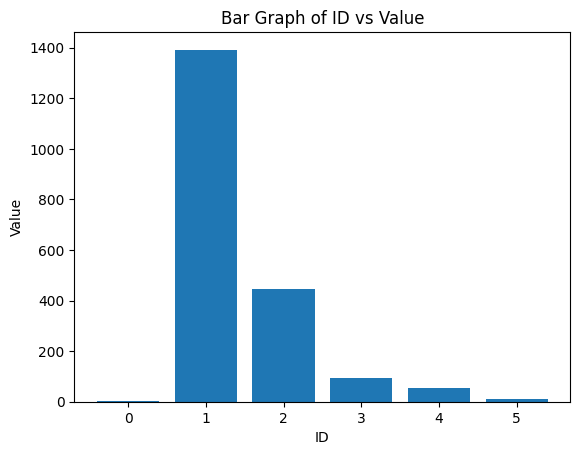

In [1]:
import pandas as pd
# add table
# 0	1
# 1	1392
# 3	94
# 5	11
# 4	56
# 2	445

table = pd.DataFrame({
    "id": [0, 1, 2, 3, 4, 5],
    "value": [1, 1392, 445, 94, 56, 11]
})

# making bar graph
import matplotlib.pyplot as plt

plt.bar(table["id"], table["value"])
plt.xlabel("ID")
plt.ylabel("Value")
plt.title("Bar Graph of ID vs Value")
plt.show()